In [1]:
# variational bayesian principal component analysis 
# based on Ilin & Raiko 2010 and associated code
# for dxn data matrix assume Y assume that row j:
# y_j = W*x_j + m + e_j, with
# p(x_j) = N(x_j; 0, I)
# p(e_j) = N(e_j; 0, v_yI)
# p(m) = N(m; 0, v_mI)
# p(W) = N(w_:k; 0, v_wkI)

# if data is missing instead consider 
# y_ij = w_i^Tx_j + m_i + e_ij for all i,j in O
# see paper for details on update rules 

# packages used
import numpy as np
import pandas as pd
from numpy.random import randn
from scipy.linalg import orth, subspace_angles
from numpy.linalg import inv, eig
import matplotlib.pyplot as plt

# read in the data
df = pd.read_csv(r'PulotuCleaned.csv')
dfAll = pd.read_csv(r'PulotuCurrent.csv')
del dfAll['Culture ']
del dfAll['Island_type']
del dfAll['Pre-Austronesian_population']
del dfAll['Distance_to_closest_landmass_inhabited_by_a_different_culture_(km)']
del dfAll['Latitude']
del dfAll['Longitude']
del dfAll['Island_Size_(km²)']
del dfAll['Distance_to_African_or_Asian_mainland_(km)_']
del df['Number_of_islands_inhabited_by_culture']
del df['Maximum_elevation_(meters)']

names1 = np.array(dfAll.columns)
names2 = np.array(df.columns)

for j in range(0,len(names2)):
    for k in range(0,len(names1)):
        if names1[k] == names2[j]:
            dfAll[names1[k]] = df[names2[j]]
            break
dfAll.values

array([[nan,  3.,  1., ...,  2.,  2.,  2.],
       [ 3., nan,  1., ..., nan,  1.,  3.],
       [ 2.,  4.,  3., ..., nan,  3.,  1.],
       ...,
       [ 2.,  4.,  3., ...,  2., nan,  2.],
       [ 2.,  3.,  4., ...,  2.,  1.,  3.],
       [ 3.,  3.,  1., ...,  2.,  2.,  2.]])

In [2]:
def rmempty(X):
        # removes totally empty columns (rows) from dta matrix X.  These columns and rows do not affect the found solution 
        data = X.copy()
        n1x, n2x = data.shape
        Ic = np.zeros([n2x,1])
        Ir = np.zeros([n1x,1])
        # for columns
        for j in range(0,n2x):
            miss = np.isnan(data[:,j])
            idx = np.where(miss == False)
            idx = idx[0]
            Ic[j] = len(idx)
        idxc = np.where(Ic > 0)
        idxc = idxc[0]
        data = data[:,idxc]
        for i in range(0,n1x):
            miss = np.isnan(data[i,:])
            idx = np.where(miss == False)
            idx = idx[0]
            Ir[i] = len(idx)
        idxr = np.where(Ir > 0)
        idxr = idxr[0]
        data = data[idxr,:]
        return data

In [3]:
def SubtractMu(Mu, X, M):
    n2 = X.shape[1]
    X = X - np.multiply(np.tile(Mu, (1, n2)),M)
    return X

In [4]:
def InitParams(n1, n2, ncomp, nobscomb):
    # opts.init -> random
    A = orth(randn(n1,ncomp))
    Av = []
    for i in range(0,n1):
        Av.append(np.eye(ncomp))
    Muv = np.ones([n1,1])
    V = 1
    S = randn(ncomp,n2)
    Sv = []
    for j in range(0,nobscomb):
        Sv.append(np.eye(ncomp))
    return A, S, V, Av, Sv, Muv
    

In [5]:
def compute_rms(X, A, S, M, ndata):
    errMx = np.multiply((X - np.matmul(A,S)),M)
    rms = np.sqrt(np.sum(errMx**2))/ndata
    return rms, errMx
    

In [6]:
def RotateToPCA(A, Av, S, Sv):
    n1 = A.shape[0]
    n2 = S.shape[1]
    mS = np.mean(S, axis=1)
    mSS = np.zeros([S.shape[0],1])
    for j in range(0,mSS.shape[0]):
        mSS[j] = mS[j]
    mS = mSS
    dMu = np.matmul(A,mS)
    S = S - np.tile(mS,(1,n2))
    covS = np.cov(S)
    for j in range(0,n2):
        covS = covS + Sv[j]
    D, VS = eig(covS)
    D = np.diag(D)
    RA = np.matmul(VS,np.sqrt(D))
    A = np.matmul(A,RA)
    covA = np.cov(A.T)
    for i in range(0,n1):
        Av[i] = np.matmul(np.matmul(RA.T,Av[i]),RA)
        covA = covA + Av[i]
    DA, VA = eig(covA)
    A = np.matmul(A,VA)
    for i in range(0,n1):
        Av[i] = np.matmul(np.matmul(VA.T,Av[i]),VA)
    R = np.matmul(np.matmul(VA.T,np.diag(1/np.diag(np.sqrt(D)))),VS.T)
    S = np.matmul(R,S)
    for j in range(0,len(Sv)):
        Sv[j] = np.matmul(np.matmul(R,Sv[j]),R.T)
    return dMu, A, Av, S, Sv
    
    
    

 

In [7]:
def pca_full(X, ncomp, maxiters):
    use_prior = 1
    use_postvar = 1
    data = X.copy()
    data = data.T
    n1x, n2x = data.shape
    # remove totally empty rows or columns
    data = rmempty(data)
    n1, n2 = data.shape
    # create missing values matrix 
    M = np.isnan(data)
    idxr, idxc = np.where(M == True)
    idxr0, idxc0 = np.where(data == 0)
    eps = np.finfo(float).eps
    data[idxr0, idxc0] = eps
    data[idxr, idxc] = 0
    M2 = np.zeros(M.shape)
    for i in range (0,M.shape[0]):
        for j in range (0,M.shape[1]):
            if M[i,j] == False:
                M2[i,j] = 1
    Nobs_i = np.zeros([n1,1])
    for j in range(0,n1):
        temp = M[j,:]
        idx = np.where(temp == False)
        idx = idx[0]
        Nobs_i[j] = len(idx)
    print(M[0,:].shape)
    ndata = int(np.sum(Nobs_i))
    earlystop = 0 # from opts in original code - come back to this 
    IX, JX = np.nonzero(data) 
    nobscomb = n2;
    # initialize model 
    A, S, V, Av, Sv, Muv = InitParams(n1, n2, ncomp, nobscomb)
    Va = 1000*np.ones([1,ncomp])
    Vmu = 1000
    Mu = np.zeros([n1,1])
    # if don't want to include bias comment out for loop below
    for j in range(0,n1):
        temp = data[j,:]
        Mu[j] = np.divide(np.sum(temp), Nobs_i[j])
    data = SubtractMu(Mu, data, M2)
    rms, errMx = compute_rms(data, A, S, M2, ndata)
    print("rms : %f" % (rms))
    Aold = A
    
    # parameters of prior for variance params 
    hpVa = 0.001
    hpVb = 0.001
    hpV = 0.001
    
    for its in range(0,maxiters):
        # burn in, prior is not updated at the beginning of learning to avoid killing sources
        if its > 100:
            # update Va, Vmu
            Vmu = np.sum(Mu**2)+np.sum(Muv)
            Vmu = (Vmu + 2*hpVa)/(n1+2*hpVb)
            Va = np.sum(A**2,axis=0)
            for i in range(0,n1):
                Va = Va+np.diag(Av[i])
            Va = (Va+2*hpVa)/(n1+2*hpVb)
        
        # update Mu
        dMu = np.multiply(np.sum(errMx,axis=1),1/Nobs_i.T).T 
        Muv = np.divide(V, Nobs_i + V/Vmu)
        th = np.divide(1,1+np.divide(V,Nobs_i)/Vmu)
        Mu_old = Mu
        Mu = np.multiply(th,Mu+dMu)
        dMu = Mu - Mu_old
        data = SubtractMu(dMu, data, M2)
        
        # update S
        for j in range(0,n2):
            A_j = np.multiply(np.tile(M2[:,j],(ncomp,1)).T,A)
            Psi = np.matmul(A_j.T,A_j) + V*np.eye(ncomp)
            idx = np.where(M2[:,j] > 0)
            idx = idx[0]
            for i in range(0,len(idx)):
                Psi = Psi + Av[idx[i]]
            invPsi = inv(Psi)
            S[:,j] = np.matmul(np.matmul(invPsi,A_j.T),data[:,j])
            Sv[j] = V*invPsi
        
        # rotate to PCA
        dMu, A, Av, S, Sv = RotateToPCA(A, Av, S, Sv)
        data = SubtractMu(dMu, data, M2)
        
        # update A
        for i in range(0,n1):
            S_i = np.multiply(np.tile(M2[i,:],(ncomp,1)),S)
            Phi = np.matmul(S_i,S_i.T) + np.diag(V/Va)
            idx = np.where(M2[i,:] > 0)
            idx = idx[0]
            for j in range(0,len(idx)):
                Phi = Phi + Sv[j]
            invPhi = inv(Phi)
            A[i,:] = np.matmul(np.matmul(data[i,:],S_i.T),invPhi)
            Av[i] = V*invPhi
        rms, errMx = compute_rms(data, A, S, M2, ndata)
        print(rms)
        
        # update V
        sXv = 0
        for r in range(0, ndata):
            sXv = sXv + np.matmul(np.matmul(A[IX[r],:],Sv[JX[r]]),A[IX[r],:].T)
            sXv = sXv + np.matmul(np.matmul(S[:,JX[r]].T,Av[IX[r]]),A[IX[r],:]) + np.sum(np.multiply(Sv[JX[r]],Av[IX[r]]))
        sXv = sXv + np.sum(Muv[IX])
        sXv = sXv + (rms**2)*ndata
        V = (sXv + 2*hpV)/(ndata+2*hpV)
        
        angleA = subspace_angles(A, Aold)
        angleA = angleA[0]
        Aold = A
    dMu, A, Av, S, Sv = RotateToPCA(A, Av, S, Sv)
    Mu = Mu+dMu
    cv = {
        "A": Av,
        "S": Sv,
        "Mu": Muv
            }
    hp = {
        "Va": Va,
        "Vmu": Vmu,
            }
    Xrec = np.matmul(A,S)+np.tile(Mu,(1,dfAll.values.shape[0]))
    return A, S, Mu, V, Xrec, cv, hp
    
    
      
    





In [8]:
A, S, Mu, V, Xrec, cv, hp = pca_full(dfAll.values,2,30)



(116,)
rms : 0.011307
0.010793237612719078
0.010086383354118591
0.009717558420823776
0.00963603296355185
0.009606906165434992
0.009594839418506343
0.009588846575432986
0.009585434480168267
0.00958333021584616
0.009581977144649933
0.009581088768513527
0.009580499641435187
0.009580107245991992
0.009579845493030538
0.009579670878020152
0.009579554467375179
0.009579476932102792
0.00957942534176676
0.009579391048100667
0.009579368272369698
0.009579353158052941
0.009579343134798518
0.009579336491605198
0.009579332090794325
0.009579329176648332
0.009579327247599766
0.00957932597100094
0.009579325126369031
0.009579324567639866
0.009579324198090646


Text(0, 0.5, 'PC 2')

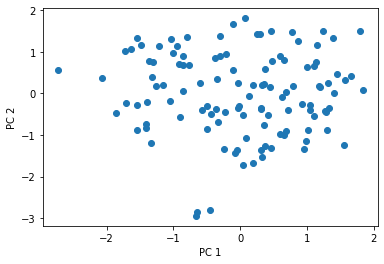

In [9]:
plt.scatter(S[0,:], S[1,:])
plt.xlabel('PC 1')
plt.ylabel('PC 2')

In [10]:
Xrec

array([[2.54767594, 3.34286498, 2.82935875, ..., 1.9126312 , 2.31702181,
        2.39613151],
       [3.16389796, 2.96726776, 2.76816026, ..., 3.35684774, 2.86805139,
        3.07129758],
       [1.94770201, 1.23179924, 2.42185233, ..., 2.43926444, 2.94291004,
        2.374431  ],
       ...,
       [1.71413538, 1.57161465, 1.66033409, ..., 1.82831889, 1.75188712,
        1.73997391],
       [2.27655626, 2.50119317, 2.20519654, ..., 2.11378513, 2.04806055,
        2.17353904],
       [1.93337272, 1.95347353, 2.21609058, ..., 1.88696212, 2.22578767,
        2.0394764 ]])

In [15]:
np.shape(cv['Mu'])

(46, 1)

In [16]:
cv['Mu']

array([[9.59511518e-07],
       [1.00897087e-06],
       [8.81713287e-07],
       [8.66107742e-07],
       [8.81713287e-07],
       [8.51044998e-07],
       [8.58510305e-07],
       [8.66107742e-07],
       [8.81713287e-07],
       [8.89728862e-07],
       [9.06205322e-07],
       [1.35930798e-06],
       [8.66107742e-07],
       [8.81713287e-07],
       [8.81713287e-07],
       [8.73840847e-07],
       [8.66107742e-07],
       [8.81713287e-07],
       [8.73840847e-07],
       [9.14674531e-07],
       [8.66107742e-07],
       [8.66107742e-07],
       [9.41059373e-07],
       [9.14674531e-07],
       [1.04117207e-06],
       [1.09966489e-06],
       [1.09966489e-06],
       [1.04117207e-06],
       [1.28776546e-06],
       [8.81713287e-07],
       [8.58510305e-07],
       [8.66107742e-07],
       [8.73840847e-07],
       [8.81713287e-07],
       [9.23303536e-07],
       [9.32096903e-07],
       [9.41059373e-07],
       [1.04117207e-06],
       [1.01948099e-06],
       [9.78701748e-07],
